<a href="https://colab.research.google.com/github/Herdol/Federated_Learning/blob/main/Meta_learnig/Pytorch_MNIST_Reptile_Single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Federated Multi-task Learning simulator 
In this simulation I tried to implement meta learning algorithms into federated learning algorithm. 
## Change log
- Multi headed CNN network converted into 1 headed.
- Update failure between steps has been fixed.

## Library imports and data preparation
Necessary libraries are imported here. Data allocation for the workers are also arranged here. In order to change the number of workers, simply change this line at ths second code block: 
```Python
  num_worker= X
```


In [ ]:
#!pip install wandb

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict, defaultdict
from sys import getsizeof
import math
import itertools
from scipy.spatial import distance
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
#import wandb

In [ ]:
#wandb.init(project="Reptilev03", name="accuracy metrics")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# The codes below fix the HTTP 503: Forbidden error while downloading MNIST
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
#######################################################
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

In [ ]:
n = 60000  # how many total elements you have
n_test = int( n * .05 )  # number of test/val elements
n_train = 5000
idx_train = list(range(50000))
idx_test = list(range(10000))
num_worker=20
train_idx=[]
test_idx=[]
train_set=[]
testset=[]
wtd=int(len(idx_train)/num_worker) #Worker Train data count for an individual node
wtec=int(len(idx_test)/num_worker) #Worker Test data count for an individual node
for widx in range(num_worker):
  train_idx=idx_train[widx*wtd:(widx+1)*wtd]
  test_idx=idx_test[widx*wtec:(widx+1)*wtec]
  train_set.append(torch.utils.data.Subset(trainset, train_idx))
  testset.append(torch.utils.data.Subset(testset, test_idx))

"""val_idx = idx[n_train:(n_train + n_test)]
test_idx = idx[(n_train + n_test):]"""

#train_set1 = torch.utils.data.Subset(trainset, train_idx)
"""trainloader = torch.utils.data.DataLoader(train_set1, batch_size=4,
                                          shuffle=False, num_workers=2)"""

'''classes = ('0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9')'''

"classes = ('0', '1', '2', '3', '4',\n           '5', '6', '7', '8', '9')"

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.1, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net=CNN()

In [ ]:
class CNN_meta(nn.Module):
    def __init__(self):
        super(CNN_meta, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 32)
        self.fc2 = nn.Linear(32, 10)
        # Meta learning outputs
        self.meta1=nn.Linear(10,5)
        self.meta1_out=nn.Linear(5,2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.1, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # Multi-head outputs for multi-task
        meta = F.relu(self.meta1(x))
        meta = self.meta1_out(meta)

        # Inference transforming to 1 dim array
        '''inference=[]
        inference.extend(even)
        inference.extend(size)
        inference=torch.reshape(torch.stack(inference),[-1,4])'''

        return F.log_softmax(meta) 

net_reptile=CNN_meta()

In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(net_reptile.parameters(), lr=0.0001)

## Network implementation
In this code block, I created a random network graph then generated the Adjacency matrix out of it.

In [ ]:
def ShortTest(weights_dict,cycle):
  test_subset=torch.utils.data.Subset(testset,np.arange(0,1000))
  testloader=torch.utils.data.DataLoader(test_subset, batch_size=1000,
                                              shuffle=False, num_workers=2)
  for widx in range(num_worker):
    net.state_dict=weights_dict[widx]
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the  Worker {}s network on the 1000 test images: {}%'.format(widx,(100 * correct / total)))
    predicted_one_hot = net(images)
    predicted=torch.argmax(predicted_one_hot,axis=1)
    cm = classification_report(predicted,labels,output_dict=True)
    wandb.log({"precision": cm['macro avg']['precision'],
                "recall": cm['macro avg']['recall'],
                "f1-score": cm['macro avg']['f1-score'],
                "accuracy": cm['accuracy'],
                "cycle": cycle,
                "Worker ID": widx})
    
    #print(cm['accuracy']) 
    #print(cm['macro avg'])         
                                                                   

In [ ]:
def FedAvg(Weights,num_worker):
  #Peer-to-Peer aggregation
  W1=Weights[0]
  FedAvg_result={}
  #print(getsizeof(FedAvg))
  for wei in W1:
    #print(wei)
    FedAvg_result[wei]=W1[wei]*0
    #print(FedAvg) #Clear the variable.
  for widx in range(num_worker):
    for wei in W1:
      temp_weights=Weights[widx]
      FedAvg_result[wei]+= temp_weights[wei]/num_worker
  """for wei in W1:
    FedAvg[wei]=FedAvg[wei]"""

  return FedAvg_result

## MAML label transformation
Labels in MNIST dataset will be represented with 4 digit label which are:
$$ [Odd,even,small,large] $$


In [ ]:
def Meta_labels(labels,Task):
  """
  This function transforms MNIST labels into spesific task labels. Tasks classify the numbers if they are
  1) Odd or Even?
  2) Smaller or Larger than 5?
  3) Product of 3?
  """
  temp=[]
  if Task==1: # Odd or even
    Transformer_matrix=[[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]]
  elif Task==2: # Smaller or larger than 5
    Transformer_matrix=[[1,0],[1,0],[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1],[0,1]]
  elif Task==3: # Product of 3
    Transformer_matrix=[[1,0],[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],[0,1],[0,1],[1,0]]
  else:
    print('Task is out borders')

  for i in labels:
    temp.append(Transformer_matrix[i])
  maml_labels=torch.tensor(temp)
  return maml_labels

## Training process
Reptile algorithm is performed in this cell. There are 9 workers in this scenario. First 3 are trained to solve odd, even task. Second 3 train to solve small or larger task. Last 3 trains to solve these with unseen digits 8 and 9. 

In [ ]:
weights=[]
temp_weights=[]
PATH = "model.pt"
weights_dict=defaultdict(list)
initial_weights=net_reptile.state_dict()
Loss_for_graph={'widx':[],
                'Gossip_cycle':[],
                'Loss': []}
Next_cycle=False
Epoch=25

Beta=0.5 # Reptile step size for meta update.
### Global model download to the workers ###
for widx in range(num_worker):
  weights_dict['weights'].append(initial_weights)

# Training begins
for epoch in range(Epoch):  # loop over the dataset multiple times

      
  #Data allocation
  for widx in range(num_worker):
    training_indicies=np.arange(0,len(train_set[0]))
    Training_subset=torch.utils.data.Subset(train_set[widx],training_indicies)
    trainloader1=torch.utils.data.DataLoader(train_set[widx],
                                            batch_size=40,shuffle=True, num_workers=2)
                                                                                 
    running_loss = 0.0
    # Lower batch size and put a step size towards last direction
    
    net_reptile.state_dict=weights_dict['weights'][widx]
    for i, data in enumerate(trainloader1,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        ##Labels will be changed for MAML
        

        # zero the optimizer parameter gradients
        optimizer.zero_grad()
        Temp_model=net_reptile.state_dict
        for layers in net_reptile.state_dict:
          Temp_model[layers]=torch.tensor(Temp_model[layers])


        # forward + backward + optimize
        #Node 0,1 and 2 have task T1,  Node 3,4 and 5 will be trained for task T2 
        if widx<10:
          task=1
        elif widx>=10:
          task=2
        elif epoch>=Epoch-5: # The workers will try to adapt new task in the last 5 epoch
          task=3
        
        labels_maml=Meta_labels(labels,task)
        outputs = net_reptile(inputs)

        loss = criterion(outputs, labels_maml.float())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        Loss_for_graph['Loss'].append(loss.item())
        Loss_for_graph['widx'].append(widx)
        if i%100==10:
          # After 50 step of update model with Reptile algorithm
          for wei in weights_dict['weights'][widx]:
            #B.append(weights_dict['weights'][widx][wei]-Temp_model[wei])
            #weights_dict['weights'][widx]= weights_dict['weights'][widx] +  Beta*(Temp_model()-weights_dict['weights'][widx])
            weights_dict['weights'][widx][wei]= weights_dict['weights'][widx][wei] +  Beta*(Temp_model[wei]-weights_dict['weights'][widx][wei])
          #print('iteration for worker = {} has been completed'.format(widx))
          # Aggregate after every third worker (Task switching)
          if widx%10==9:
            for idx in range(widx):
              weights_dict['weights'][idx]=FedAvg(weights_dict['weights'],widx)
          break
    print('Worker {} finished training task {}'.format(widx,task))
  ### Meta learning is done for worker
  print('Worker {} Finished Training with loss: {}'.format(widx,running_loss/ i))
  print('Epoch {} has ben finished'.format(epoch))
  print('***** New cycle begins *****')
  #weights.append(prev_grads)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Worker 0 finished training task 1
Worker 1 finished training task 1
Worker 2 finished training task 1
Worker 3 finished training task 1
Worker 4 finished training task 1
Worker 5 finished training task 1
Worker 6 finished training task 1
Worker 7 finished training task 1
Worker 8 finished training task 1
Worker 9 finished training task 1
Worker 10 finished training task 2
Worker 11 finished training task 2
Worker 12 finished training task 2
Worker 13 finished training task 2
Worker 14 finished training task 2
Worker 15 finished training task 2
Worker 16 finished training task 2
Worker 17 finished training task 2
Worker 18 finished training task 2
Worker 19 finished training task 2
Worker 19 Finished Training with loss: 1.8106745958328248
Epoch 0 has ben finished
***** New cycle begins *****
Worker 0 finished training task 1
Worker 1 finished training task 1
Worker 2 finished training task 1
Worker 3 finished training task 1
Worker 4 finished training task 1
Worker 5 finished training t

In [ ]:
#optimizer.state_dict()

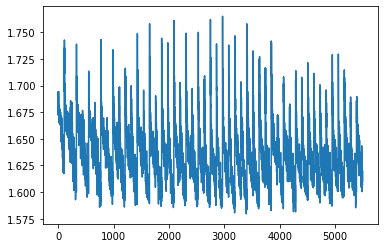

In [ ]:
plt.plot(Loss_for_graph['Loss'])


In [ ]:
#print(weights_dict['weights'][widx])
#print(Temp_model)
break here 

SyntaxError: ignored

In [ ]:
'''print(labels_maml)
print(outputs)'''

In [ ]:
a=weights_dict['weights'][widx]
b=Temp_model
B=[]
for wei in weights_dict['weights'][widx]:
  B.append(weights_dict['weights'][widx][wei]-Temp_model[wei])
print(B)

### Model saving examples

I try to find better ways to register models for each worker, and call them later.

In [ ]:
PATH="model.pt"
for i in range(10):
  torch.save({
              'model{}'.format(i): net_maml.state_dict,
              'modelB_state_dict': net.state_dict(),
              'optimizerA_state_dict': optimizer.state_dict(),
              'optimizerB_state_dict': optimizer.state_dict()}, PATH)

modelA = net_maml
checkpoint = torch.load(PATH)
#print(checkpoint)
#modelA.load_state_dict(checkpoint['model9'])
